# replicate the sine model to check if we can deploy the model onto the MCU

In [149]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset

from itertools import chain

import onnx

import numpy as np
import matplotlib.pyplot as plt
import math
import time

### check if mps support is available -metal performance shaders

In [13]:
torch.backends.mps.is_available()

True

In [14]:
torch.backends.mps.is_built()

True

In [15]:
# we can use it by setting the mps device
mps = torch.device("mps")
cpu = torch.device("cpu")

# create data

In [16]:
SAMPLES = 100000
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

In [19]:
# generate random numbers
x_values = np.random.uniform(low=0, high=2*math.pi, size=SAMPLES)

# shuffle the values
np.random.shuffle(x_values)

# calculate corresponding y values
y_values = np.sin(x_values)

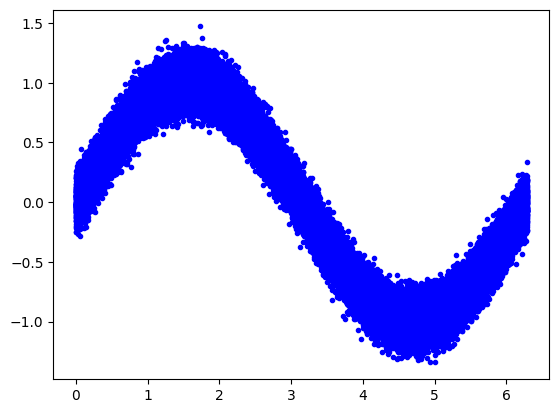

In [23]:
# add noise
y_values += 0.1 * np.random.randn(y_values.shape[0])

plt.plot(x_values, y_values, 'b.')
plt.show()

In [30]:
# 60% for training, 20% for test and 20% for validation
TRAIN_SPLIT = int(0.6 * SAMPLES)
TEST_SPLIT = int(0.2 * SAMPLES + TRAIN_SPLIT)

x_train, x_validate, x_test = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_validate, y_test = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

assert (x_train.size + x_validate.size + x_test.size) == SAMPLES

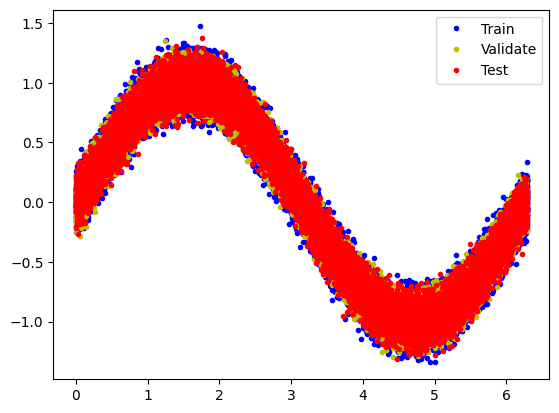

In [31]:
# Plot the data in each partition in different colors:
plt.plot(x_train, y_train, 'b.', label="Train")
plt.plot(x_validate, y_validate, 'y.', label="Validate")
plt.plot(x_test, y_test, 'r.', label="Test")
plt.legend()
plt.show()

# model


In [32]:
# shape should resemble the one used in the tensorflow tutorial

class Mlp(nn.Module):
    def __init__(self):
        super(Mlp, self).__init__()
        # input layer
        self.fc1 = nn.Linear(1, 16)
        # hidden layer
        self.fc2 = nn.Linear(16, 16)
        # output layer, no activation
        self.fc3 = nn.Linear(16, 1)
    
    def forward(self, x):
        # forward loop to propagate through the network
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## implement dataset and data loader

In [33]:
class SineDataset(Dataset):
    
    def __init__(self, data):
         # data is tuple of input and target
        self.x_data = data[0]
        self.y_data = data[1]
        assert len(self.x_data) == len(self.y_data)
        
    def __len__(self):
        return len(self.x_data)
    
    def __getitem__(self, idx):
        # transform data to tensor and unsqueeze to fit the dimensions
        example = torch.unsqueeze(torch.tensor(self.x_data[idx], dtype=torch.float), dim=0)
        target = torch.unsqueeze(torch.tensor(self.y_data[idx], dtype=torch.float), dim=0)
        
        return example, target

In [34]:
def train_with_loader(model, loader, opti, crit, device):
    
    model.to(device)
    
    epoch_train_loss = list()

    for _data in loader:
        # send data to device
        _inpt = _data[0].to(device)
        _trgt = _data[1].to(device)

        # make prediction
        _otp = model(_inpt)
        # compute loss
        loss = crit(_otp.to(device), _trgt).requires_grad_(True)
        # zero out gradients
        opti.zero_grad()
        # backward pass
        loss.backward()       
        # optimization step
        opti.step()

        epoch_train_loss.append(loss.detach().cpu().numpy())

    return model, np.average(epoch_train_loss)

In [138]:
def validate_with_loader(model, loader, device, crit):

    model.to(device)

    val_loss = []
    # store predictions
    predictions = []
    for _data in loader:
        # send data to device
        _inpt = _data[0].to(device)
        _trgt = _data[1].to(device)

        # make prediction
        _otp = model(_inpt)
        predictions.append(_otp.detach().numpy())
        # compute loss
        loss = crit(_otp.to(device), _trgt)

        val_loss.append(loss.detach().cpu().numpy())
    
    return predictions, np.average(val_loss)

In [36]:
EPOCHS = 1000
LR = 0.001
BATCH_SIZE = 400
DEVICE = cpu

criterion = nn.MSELoss()

# init model and send to desired device
mlp_3 = Mlp()

optimizer = torch.optim.RMSprop(mlp_3.parameters(), lr=LR)

# init datasets
train_ds = SineDataset((x_train, y_train))
val_ds = SineDataset((x_validate, y_validate))

# dataloaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

In [37]:
start = time.time()

train_loss = list()
val_loss = list()

for epoch in range(EPOCHS):
    # training step
    mlp_3.train()
    mlp_3, t_loss_epoch = train_with_loader(mlp_3, train_loader, optimizer, criterion, DEVICE)
    train_loss.append(t_loss_epoch)
    
    # validation step
    mlp_3.eval()
    _, v_loss_epoch = validate_with_loader(mlp_3, val_loader, DEVICE, criterion)
    val_loss.append(v_loss_epoch)
    
    print(f"EPOCH {epoch+1}: Training loss is {t_loss_epoch:.4f} - Validation loss is {v_loss_epoch:.4f}")

duration = round((time.time() - start), 2)
print(f"That took {duration} seconds")

EPOCH 1: Training loss is 0.2288 - Validation loss is 0.1449
EPOCH 2: Training loss is 0.1381 - Validation loss is 0.1309
EPOCH 3: Training loss is 0.1236 - Validation loss is 0.1148
EPOCH 4: Training loss is 0.1060 - Validation loss is 0.0963
EPOCH 5: Training loss is 0.0869 - Validation loss is 0.0773
EPOCH 6: Training loss is 0.0681 - Validation loss is 0.0600
EPOCH 7: Training loss is 0.0516 - Validation loss is 0.0460
EPOCH 8: Training loss is 0.0384 - Validation loss is 0.0368
EPOCH 9: Training loss is 0.0291 - Validation loss is 0.0305
EPOCH 10: Training loss is 0.0230 - Validation loss is 0.0248
EPOCH 11: Training loss is 0.0194 - Validation loss is 0.0224
EPOCH 12: Training loss is 0.0173 - Validation loss is 0.0206
EPOCH 13: Training loss is 0.0163 - Validation loss is 0.0195
EPOCH 14: Training loss is 0.0159 - Validation loss is 0.0158
EPOCH 15: Training loss is 0.0156 - Validation loss is 0.0143
EPOCH 16: Training loss is 0.0155 - Validation loss is 0.0136
EPOCH 17: Trainin

EPOCH 133: Training loss is 0.0117 - Validation loss is 0.0119
EPOCH 134: Training loss is 0.0117 - Validation loss is 0.0119
EPOCH 135: Training loss is 0.0117 - Validation loss is 0.0120
EPOCH 136: Training loss is 0.0117 - Validation loss is 0.0120
EPOCH 137: Training loss is 0.0117 - Validation loss is 0.0119
EPOCH 138: Training loss is 0.0117 - Validation loss is 0.0120
EPOCH 139: Training loss is 0.0117 - Validation loss is 0.0120
EPOCH 140: Training loss is 0.0116 - Validation loss is 0.0120
EPOCH 141: Training loss is 0.0116 - Validation loss is 0.0119
EPOCH 142: Training loss is 0.0116 - Validation loss is 0.0119
EPOCH 143: Training loss is 0.0116 - Validation loss is 0.0119
EPOCH 144: Training loss is 0.0116 - Validation loss is 0.0118
EPOCH 145: Training loss is 0.0116 - Validation loss is 0.0118
EPOCH 146: Training loss is 0.0116 - Validation loss is 0.0118
EPOCH 147: Training loss is 0.0116 - Validation loss is 0.0117
EPOCH 148: Training loss is 0.0116 - Validation loss is

EPOCH 264: Training loss is 0.0109 - Validation loss is 0.0107
EPOCH 265: Training loss is 0.0109 - Validation loss is 0.0107
EPOCH 266: Training loss is 0.0109 - Validation loss is 0.0107
EPOCH 267: Training loss is 0.0109 - Validation loss is 0.0107
EPOCH 268: Training loss is 0.0109 - Validation loss is 0.0107
EPOCH 269: Training loss is 0.0109 - Validation loss is 0.0107
EPOCH 270: Training loss is 0.0109 - Validation loss is 0.0106
EPOCH 271: Training loss is 0.0109 - Validation loss is 0.0107
EPOCH 272: Training loss is 0.0109 - Validation loss is 0.0107
EPOCH 273: Training loss is 0.0109 - Validation loss is 0.0106
EPOCH 274: Training loss is 0.0109 - Validation loss is 0.0106
EPOCH 275: Training loss is 0.0109 - Validation loss is 0.0106
EPOCH 276: Training loss is 0.0109 - Validation loss is 0.0106
EPOCH 277: Training loss is 0.0109 - Validation loss is 0.0106
EPOCH 278: Training loss is 0.0109 - Validation loss is 0.0106
EPOCH 279: Training loss is 0.0109 - Validation loss is

EPOCH 395: Training loss is 0.0107 - Validation loss is 0.0104
EPOCH 396: Training loss is 0.0107 - Validation loss is 0.0104
EPOCH 397: Training loss is 0.0107 - Validation loss is 0.0104
EPOCH 398: Training loss is 0.0107 - Validation loss is 0.0104
EPOCH 399: Training loss is 0.0107 - Validation loss is 0.0104
EPOCH 400: Training loss is 0.0107 - Validation loss is 0.0104
EPOCH 401: Training loss is 0.0107 - Validation loss is 0.0104
EPOCH 402: Training loss is 0.0107 - Validation loss is 0.0104
EPOCH 403: Training loss is 0.0107 - Validation loss is 0.0104
EPOCH 404: Training loss is 0.0106 - Validation loss is 0.0104
EPOCH 405: Training loss is 0.0106 - Validation loss is 0.0104
EPOCH 406: Training loss is 0.0106 - Validation loss is 0.0104
EPOCH 407: Training loss is 0.0106 - Validation loss is 0.0104
EPOCH 408: Training loss is 0.0106 - Validation loss is 0.0104
EPOCH 409: Training loss is 0.0106 - Validation loss is 0.0104
EPOCH 410: Training loss is 0.0106 - Validation loss is

EPOCH 526: Training loss is 0.0106 - Validation loss is 0.0103
EPOCH 527: Training loss is 0.0106 - Validation loss is 0.0103
EPOCH 528: Training loss is 0.0106 - Validation loss is 0.0103
EPOCH 529: Training loss is 0.0106 - Validation loss is 0.0103
EPOCH 530: Training loss is 0.0106 - Validation loss is 0.0103
EPOCH 531: Training loss is 0.0106 - Validation loss is 0.0103
EPOCH 532: Training loss is 0.0106 - Validation loss is 0.0103
EPOCH 533: Training loss is 0.0105 - Validation loss is 0.0103
EPOCH 534: Training loss is 0.0105 - Validation loss is 0.0103
EPOCH 535: Training loss is 0.0105 - Validation loss is 0.0103
EPOCH 536: Training loss is 0.0105 - Validation loss is 0.0103
EPOCH 537: Training loss is 0.0105 - Validation loss is 0.0103
EPOCH 538: Training loss is 0.0105 - Validation loss is 0.0103
EPOCH 539: Training loss is 0.0105 - Validation loss is 0.0103
EPOCH 540: Training loss is 0.0105 - Validation loss is 0.0103
EPOCH 541: Training loss is 0.0105 - Validation loss is

EPOCH 657: Training loss is 0.0104 - Validation loss is 0.0102
EPOCH 658: Training loss is 0.0104 - Validation loss is 0.0102
EPOCH 659: Training loss is 0.0104 - Validation loss is 0.0102
EPOCH 660: Training loss is 0.0104 - Validation loss is 0.0102
EPOCH 661: Training loss is 0.0104 - Validation loss is 0.0102
EPOCH 662: Training loss is 0.0104 - Validation loss is 0.0102
EPOCH 663: Training loss is 0.0104 - Validation loss is 0.0102
EPOCH 664: Training loss is 0.0104 - Validation loss is 0.0102
EPOCH 665: Training loss is 0.0104 - Validation loss is 0.0102
EPOCH 666: Training loss is 0.0104 - Validation loss is 0.0102
EPOCH 667: Training loss is 0.0104 - Validation loss is 0.0102
EPOCH 668: Training loss is 0.0104 - Validation loss is 0.0102
EPOCH 669: Training loss is 0.0104 - Validation loss is 0.0102
EPOCH 670: Training loss is 0.0104 - Validation loss is 0.0102
EPOCH 671: Training loss is 0.0104 - Validation loss is 0.0102
EPOCH 672: Training loss is 0.0104 - Validation loss is

EPOCH 788: Training loss is 0.0104 - Validation loss is 0.0102
EPOCH 789: Training loss is 0.0104 - Validation loss is 0.0102
EPOCH 790: Training loss is 0.0104 - Validation loss is 0.0102
EPOCH 791: Training loss is 0.0104 - Validation loss is 0.0102
EPOCH 792: Training loss is 0.0104 - Validation loss is 0.0102
EPOCH 793: Training loss is 0.0104 - Validation loss is 0.0102
EPOCH 794: Training loss is 0.0104 - Validation loss is 0.0102
EPOCH 795: Training loss is 0.0104 - Validation loss is 0.0102
EPOCH 796: Training loss is 0.0104 - Validation loss is 0.0102
EPOCH 797: Training loss is 0.0104 - Validation loss is 0.0102
EPOCH 798: Training loss is 0.0104 - Validation loss is 0.0102
EPOCH 799: Training loss is 0.0104 - Validation loss is 0.0102
EPOCH 800: Training loss is 0.0104 - Validation loss is 0.0102
EPOCH 801: Training loss is 0.0104 - Validation loss is 0.0102
EPOCH 802: Training loss is 0.0104 - Validation loss is 0.0102
EPOCH 803: Training loss is 0.0104 - Validation loss is

EPOCH 919: Training loss is 0.0103 - Validation loss is 0.0102
EPOCH 920: Training loss is 0.0103 - Validation loss is 0.0102
EPOCH 921: Training loss is 0.0103 - Validation loss is 0.0102
EPOCH 922: Training loss is 0.0103 - Validation loss is 0.0102
EPOCH 923: Training loss is 0.0103 - Validation loss is 0.0102
EPOCH 924: Training loss is 0.0103 - Validation loss is 0.0102
EPOCH 925: Training loss is 0.0103 - Validation loss is 0.0102
EPOCH 926: Training loss is 0.0103 - Validation loss is 0.0102
EPOCH 927: Training loss is 0.0103 - Validation loss is 0.0102
EPOCH 928: Training loss is 0.0103 - Validation loss is 0.0102
EPOCH 929: Training loss is 0.0103 - Validation loss is 0.0102
EPOCH 930: Training loss is 0.0103 - Validation loss is 0.0102
EPOCH 931: Training loss is 0.0103 - Validation loss is 0.0102
EPOCH 932: Training loss is 0.0103 - Validation loss is 0.0102
EPOCH 933: Training loss is 0.0103 - Validation loss is 0.0102
EPOCH 934: Training loss is 0.0103 - Validation loss is

In [162]:
test_ds = SineDataset((x_test, y_test))
test_loader = DataLoader(test_ds, batch_size=10, shuffle=False)

initial_predictions, test_loss = validate_with_loader(mlp_3, test_loader, DEVICE, criterion)

print(test_loss)

0.010417597


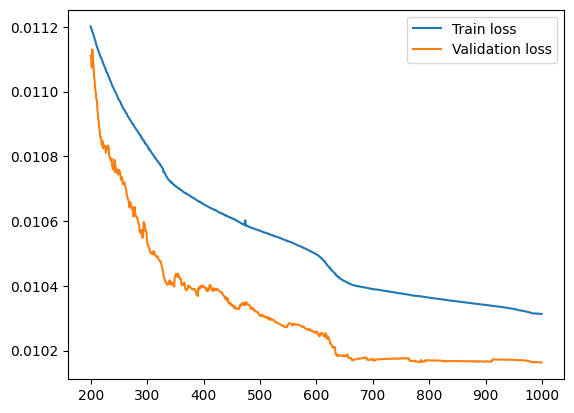

In [39]:
# we cut off the first epochs to get a better view
CUTOFF = 200

plt.plot(range(EPOCHS)[CUTOFF:],train_loss[CUTOFF:], label='Train loss')
plt.plot(range(EPOCHS)[CUTOFF:], val_loss[CUTOFF:], label='Validation loss')
plt.legend()
plt.show()

## bottom line is: cpu is much faster here

# store model

In [42]:
# save torch model as is.mlp_3he name gives you an idea of number of epochs trained
torch.save(mlp_3, "../models/torch_sine_1000e.model")

In [43]:
# create an example loader yielding only one example
example_loader = DataLoader(train_ds, batch_size=1, shuffle=True)

In [45]:
# get example input tensor
x = next(iter(example_loader))[0]

print(x.shape, x)

torch.Size([1, 1]) tensor([[4.7093]])


In [91]:
x.data

tensor([[4.7093]])

In [114]:
# check output before conversion
output_torch = mlp_3(x)

In [80]:
# define model name
onnx_model_name = "../models/torch_sine_1000e.onnx"

# store as onnx file
# from: https://onnxruntime.ai/docs/performance/graph-optimizations.html
# Constant Folding: Statically computes parts of the graph that rely only on constant initializers. 
# This eliminates the need to compute them during runtime
torch.onnx.export(mlp_3, x, onnx_model_name, export_params=True, do_constant_folding=True)

In [81]:
# load model
onnx_model = onnx.load(onnx_model_name)

# check model
onnx.checker.check_model(onnx_model)

# load model in tensorflow, test and convert

In [49]:
import tensorflow as tf
from onnx_tf.backend import prepare

In [108]:
# load onnx model
tf_onnx_model = onnx.load(onnx_model_name)

# export graph
onnx_graph_file = "../models/tf_onnx_1000e.graph"
prepare(tf_onnx_model).export_graph(onnx_graph_file)

# load model in tensorflow
tf_model = tf.saved_model.load(onnx_graph_file)

type(tf_model)

INFO:tensorflow:Assets written to: ../models/tf_onnx_1000e.graph/assets


INFO:tensorflow:Assets written to: ../models/tf_onnx_1000e.graph/assets


tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject

In [109]:
# serving mode of model
infer = tf_model.signatures["serving_default"]

outputs = list(infer.structured_outputs)[0]

In [112]:
x_tf = tf.constant(x.numpy())

print(x_tf)

tf.Tensor([[4.709339]], shape=(1, 1), dtype=float32)


In [120]:
# check model after conversion

output_tf = infer(x_tf)[outputs]

# compare results

print(f"TF model prediction is {output_tf[0][0]} and Torch model prediction is {output_torch[0][0]}")

TF model prediction is -0.973888099193573 and Torch model prediction is -0.973888099193573


# convert model to tensorflow light

In [122]:
# load convert model from onnx file
saved_model_converter = tf.lite.TFLiteConverter.from_saved_model(onnx_graph_file)
tflite_saved_model = saved_model_converter.convert()

# store model on disc
torch_tflite_file = "../models/sine_model_torch.tflite"

with open(torch_tflite_file, "wb") as f:
    f.write(tflite_saved_model)

2023-01-29 19:11:11.223039: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-01-29 19:11:11.223057: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-01-29 19:11:11.223121: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: ../models/tf_onnx_1000e.graph
2023-01-29 19:11:11.223338: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-01-29 19:11:11.223343: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: ../models/tf_onnx_1000e.graph
2023-01-29 19:11:11.223730: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-01-29 19:11:11.228003: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: ../models/tf_onnx_1000e.graph
2023-01-29 19:11:11.229904: I tensorflow/cc/saved_model/loader.cc:305] SavedModel load for tags { ser

In [129]:
# init an interpreter
tflite_torch_model = tf.lite.Interpreter(torch_tflite_file)

# allocate memory for model
tflite_torch_model.allocate_tensors()

# get indexes of input and output tensors
# for inference, we replace the value of the input tensor with our data
tflite_model_input_ind = tflite_torch_model.get_input_details()[0]["index"]
# to retrieve the prediction, we check the value of the output tensor
tflite_model_output_ind = tflite_torch_model.get_output_details()[0]["index"]

In [159]:
# prediction with tflite model

# store preds
tflite_predictions = []

for _inp in x_test:
    # tf compatible tensor of test data
    x_tensor = tf.convert_to_tensor([[_inp]], dtype=np.float32)
    # replace value of first input tensor with our data
    tflite_torch_model.set_tensor(tflite_model_input_ind, x_tensor)
    # run inference
    tflite_torch_model.invoke()
    tflite_predictions.append(tflite_torch_model.get_tensor(tflite_model_output_ind)[0])

In [161]:
tflite_predictions

[array([0.64461505], dtype=float32),
 array([-0.31631953], dtype=float32),
 array([0.9184289], dtype=float32),
 array([0.1506139], dtype=float32),
 array([0.47412527], dtype=float32),
 array([0.9645629], dtype=float32),
 array([0.9765557], dtype=float32),
 array([0.919989], dtype=float32),
 array([-0.9308859], dtype=float32),
 array([0.820778], dtype=float32),
 array([0.4879744], dtype=float32),
 array([0.9373466], dtype=float32),
 array([-0.01067305], dtype=float32),
 array([0.914544], dtype=float32),
 array([-0.5241508], dtype=float32),
 array([-2.6166439e-05], dtype=float32),
 array([-0.9552734], dtype=float32),
 array([-0.15480065], dtype=float32),
 array([0.820866], dtype=float32),
 array([-0.30283874], dtype=float32),
 array([0.24192595], dtype=float32),
 array([0.74624646], dtype=float32),
 array([-0.32729596], dtype=float32),
 array([0.6123904], dtype=float32),
 array([0.37541473], dtype=float32),
 array([0.7808354], dtype=float32),
 array([0.1526677], dtype=float32),
 array([-

In [163]:
# denest the torch predictions, which appear in batches
initial_predictions = list(chain.from_iterable(initial_predictions))

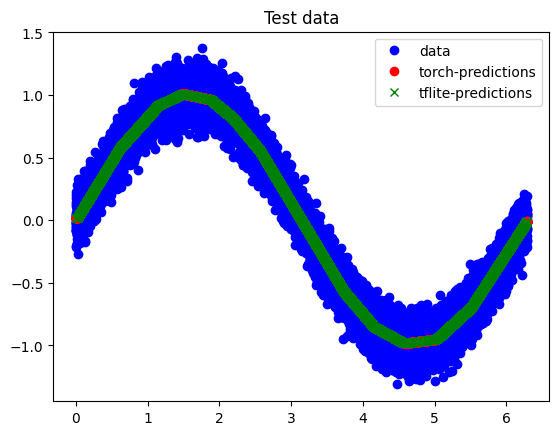

In [167]:
# predictions overlay nicely
plt.clf()
plt.title("Test data")
plt.plot(x_test, y_test, "bo", label="data")
plt.plot(x_test, initial_predictions, "ro", label="torch-predictions")
plt.plot(x_test, tflite_predictions, "gx", label="tflite-predictions")
plt.legend()
plt.show()

# now with quantization optimization